In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
from jax.scipy.special import expit as sigmoid
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.mcmc_models import GPclassifier
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.input_priors import uniform_prior

onp.random.seed(1234)

## Generate some data

In [2]:
def test_fun(X):
    return ( 0.5 + np.sin(2.5*X[:,0]*np.pi)/3 - X[:,1]) > 0

def boundary(X):
    return 0.5 + np.sin(2.5*X[:,0]*np.pi)/3

In [3]:
N = 20
D = 2
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
bounds = {'lb': lb, 'ub': ub}
p_x = uniform_prior(lb, ub)

# Training data
X = lb + (ub - lb)*lhs(2,N) # generate data with a Latin hypercube desing
y = 1.0*test_fun(X)

# Test data
nn = 50
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = 1.0*test_fun(X_star)

## Model setup

In [4]:
options = {'kernel': 'RBF',
           'criterion': 'CLSF', 
           'input_prior': p_x,
           'kappa': 1.0,
           'nIter': 0}
mcmc_settings = {'num_warmup': 500,
                 'num_samples': 20,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
gp_model = GPclassifier(options)

## Training

In [5]:
rng_key = random.PRNGKey(123)
data = {'X': X, 'y': y}
print('Train GP...')
key_train, key_test = random.split(rng_key)
samples = gp_model.train(data,
                         key_train,
                         mcmc_settings,
                         verbose = True)

Train GP...


sample: 100%|██████████| 520/520 [00:06<00:00, 77.10it/s, 15 steps of size 2.48e-01. acc. prob=0.79]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
            beta      0.54      0.73      0.49     -0.73      1.59     28.16      1.08
          eta[0]     -0.04      1.10      0.06     -1.55      1.43      8.14      1.30
          eta[1]      0.90      0.48      0.82      0.22      1.57     46.54      0.96
          eta[2]      0.64      0.75      0.56     -0.55      1.88     12.08      0.95
          eta[3]      0.22      0.98      0.04     -1.32      1.75     17.54      0.97
          eta[4]      0.68      0.69      0.62     -0.85      1.49     13.09      1.12
          eta[5]     -0.34      1.34     -0.25     -2.20      1.76     22.36      0.98
          eta[6]      0.20      0.78      0.02     -1.03      1.38     27.00      0.95
          eta[7]      0.21      0.57      0.11     -0.93      0.90     23.95      0.96
          eta[8]     -0.65      1.06     -0.33     -2.44      0.80     16.80      0.99
          eta[9]      0.15      1.11      

In [6]:
# Compute predictions
rng_keys = random.split(key_test, 
                        mcmc_settings['num_samples'] * mcmc_settings['num_chains'])
kwargs = {'samples': samples,
          'batch': data,
          'bounds': bounds,
          'rng_key': key_test,
          'rng_keys': rng_keys}
mean, std = gp_model.predict(X_star, **kwargs)
acq_fn = lambda x: gp_model.acquisition(x, **kwargs)
acq = vmap(acq_fn)(X_star)
new_X = gp_model.compute_next_point_gs(X_star, **kwargs)
acc_total = np.sum(np.rint(sigmoid(mean)) == y_star)/y_star.shape[0]
print('Classification accuracy: %f%%' % (acc_total))

Classification accuracy: 0.880800%


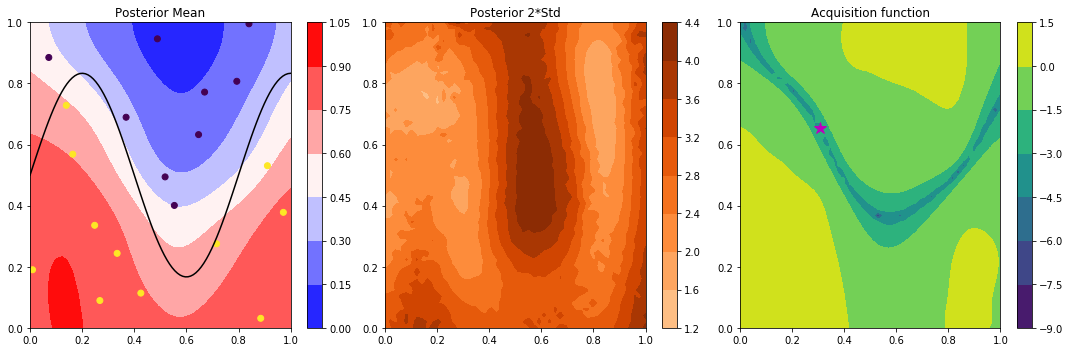

In [7]:
Mplot = mean.reshape(nn,nn)
Splot = std.reshape(nn,nn)
Aplot = acq.reshape(nn,nn)

xx = np.linspace(0, 1, 100)[:,None]

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.contourf(XX, YY, sigmoid(Mplot), cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
plt.colorbar()
plt.plot(xx , boundary(xx), 'k')
plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Posterior Mean')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.contourf(XX, YY, 2.0*Splot, cmap=plt.get_cmap('Oranges'), vmin=0)
plt.colorbar()
# plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Posterior 2*Std')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.contourf(XX, YY, Aplot)
plt.plot(new_X[0,0], new_X[0,1], 'm*', ms = 12)
plt.colorbar()
# plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Acquisition function')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

In [8]:
# Fit GMM
kwargs = {'samples': samples,
          'batch': data,
          'bounds': bounds,
          'rng_key': key_test,
          'rng_keys': rng_keys}
gmm_vars = gp_model.fit_gmm(**kwargs, N_samples = 10000)

In [9]:
kwargs = {'samples': samples,
          'batch': data,
          'bounds': bounds,
          'rng_key': key_test,
          'gmm_vars': gmm_vars}
w_pred = compute_w_gmm(X_star, **kwargs)
acq = np.log(np.abs(mean)+1e-8) - np.log(std + 1e-8) - np.log(w_pred + 1e-8)
# acq = np.abs(mean)/(std*w_pred)
new_X = X_star[np.argmin(acq), :]

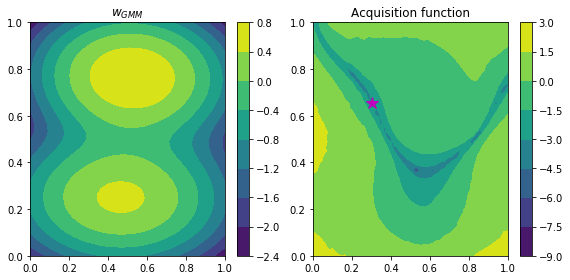

In [10]:
Wplot = w_pred.reshape(nn,nn)
AAplot = acq.reshape(nn,nn)

plt.figure(figsize = (8,4))
plt.subplot(1, 2, 1)
plt.contourf(XX, YY, np.log(Wplot))
plt.colorbar()
plt.title('$w_{GMM}$')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.contourf(XX, YY, AAplot)
plt.colorbar()
plt.plot(new_X[0], new_X[1], 'm*', ms = 12)
plt.title('Acquisition function')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()